## PSD of BaroData

In [2]:
import matplotlib.pyplot as plt
import os

from obspy import UTCDateTime, read, Stream, Trace, read_inventory
from obspy import read_inventory

from andbro__read_sds import __read_sds
from andbro__load_FURT_stream import __load_furt_stream

import warnings
warnings.filterwarnings('ignore')

In [3]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

In [7]:
def __welch_psd(arr, dt, twin_sec=60):

    from scipy.signal import welch
    from scipy.signal.windows import hann

    nblock = int(1/dt * twin_sec)
    overlap = int(0.5*nblock)
    win = hann(nblock, True)

    ff, Pxx = welch(arr,
                    fs=1/dt,
                    window=win, noverlap=overlap,
                    nfft=nblock,
                    scaling="density",
                    return_onesided=True)

    return ff, Pxx

In [194]:
# tbeg, tend = UTCDateTime("2023-09-03"), UTCDateTime("2023-09-07")
tbeg, tend = UTCDateTime("2023-11-05"), UTCDateTime("2023-11-20")

path_to_figs = root_path+"Documents/ROMY/ROMY_infrasound/figures/"

## time of inlet below gravel
# name = "t_gravel"
# t_gravel = UTCDateTime("2023-09-20 12:00")
# tbeg, tend = UTCDateTime("2023-11-05"), UTCDateTime("2023-11-20")

##
# name = "t_gravel_filter"
# t_gravel_filter = UTCDateTime("2023-10-05 12:00")
# tbeg, tend = UTCDateTime("2023-11-05"), UTCDateTime("2023-11-20")

##
name = "t_mushroom_filter"
t_mushroom_filter = UTCDateTime("2023-10-13 16:00")
tbeg, tend = UTCDateTime("2023-11-06 10:00"), UTCDateTime("2023-11-06 13:00")

##
# name = "t_mushroom_foam_filter"
# t_mushroom_foam_filter = UTCDateTime("2023-11-09 13:00")
# tbeg, tend = UTCDateTime("2023-11-11 04:00"), UTCDateTime("2023-11-11 07:00")

##
# name = "t_mushroom_foam_porous"
# t_mushroom_foam_porous = UTCDateTime("2023-11-17 12:00")
# tbeg, tend = UTCDateTime("2023-11-19 09:00"), UTCDateTime("2023-11-19 12:00")


### FFBI DATA

2 Trace(s) in Stream:
BW.FFBI..BDF | 2023-11-06T10:00:00.004998Z - 2023-11-06T13:00:00.004998Z | 40.0 Hz, 432001 samples
BW.FFBI..BDO | 2023-11-06T10:00:00.005000Z - 2023-11-06T13:00:00.005000Z | 40.0 Hz, 432001 samples


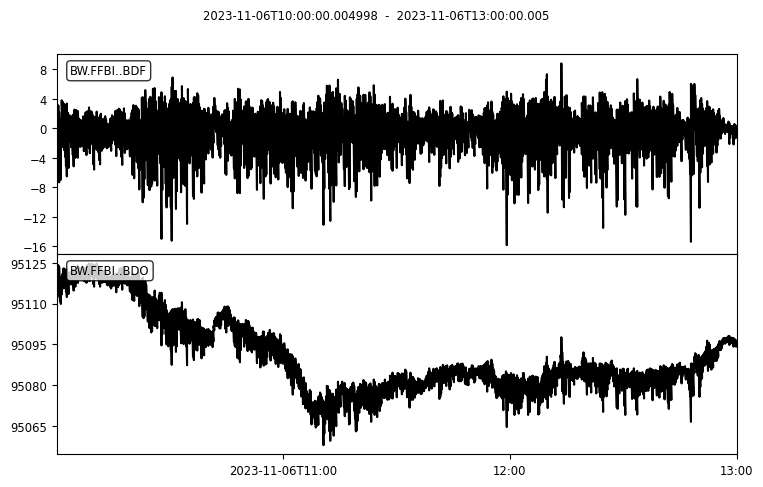

In [195]:

## period to check data... one sided differential signals...
# tbeg, tend = "2023-08-13","2023-08-20"
# ffbi = __read_sds("/import/kilauea-data/LNM2/mb2000/sds/", "BW.IROMY..BD*", tbeg, tend)

ffbi = __read_sds(root_path+"/bay200/mseed_online/archive/", "BW.FFBI..BD*", tbeg, tend)
# ffbi = __read_sds("/home/andbro/bay200/", "BW.FFBI..BD*", tbeg, tend)

ffbi_inv = read_inventory(root_path+"/Documents/ROMY/ROMY_infrasound/station_BW_FFBI.xml")

if len(ffbi) != 2:
    ffbi.merge();

# ffbi = ffbi.remove_response(ffbi_inv)

## remove gain and sensitivity
for tr in ffbi:
    if "F" in tr.stats.channel:
        # tr = tr.remove_response(ffbi_inv)
        tr.data = tr.data *1.589e-6 /0.02  # gain=1 sensitivity_reftek=6.28099e5count/V; sensitivity_mb2005=0.02 VPa
    elif "O" in tr.stats.channel:
        tr.data = tr.data *1.589e-6 *1e5   # gain=1 sensitivity_reftek=6.28099e5count/V; sensitivity = 1 mV/hPa

ffbi.merge();

print(ffbi)

ffbi.plot(equal_scale=False);

### Compute PSD

In [196]:
f_ffbi, psd_ffbi = __welch_psd(ffbi.select(channel="BDF")[0].data,
                               ffbi.select(channel="BDF")[0].stats.delta,
                               twin_sec=3600,
                               )

In [197]:
from functions.get_fband_average import __get_fband_average

In [198]:
output = __get_fband_average(f_ffbi, psd_ffbi, faction_of_octave=12, average="mean")
f_ffbi, psd_ffbi = output['fcenter'], output['psd_means']

 -> set fmin to 1e-10 instead of 0


### Write

In [199]:
def __save_to_pickle(obj, path, name):

    import os
    import pickle

    ofile = open(path+name+".pkl", 'wb')
    pickle.dump(obj, ofile)

    if os.path.isfile(path+name+".pkl"):
        print(f"\n -> created:  {path}{name}.pkl")

In [200]:
out = {}
out['freq'] = f_ffbi
out['psd'] = psd_ffbi
out['data'] = ffbi.select(channel="BDF")[0].data
out['time'] =ffbi.select(channel="BDF")[0].times()
out['name'] = name

__save_to_pickle(out, "./data/", f"{name}")


 -> created:  ./data/t_mushroom_filter.pkl


### Load Data

In [201]:
from pandas import read_pickle

data1 = read_pickle("./data/t_mushroom_foam_porous.pkl")

data2 = read_pickle("./data/t_mushroom_foam_filter.pkl")

data3 = read_pickle("./data/t_mushroom_filter.pkl")


### Plotting

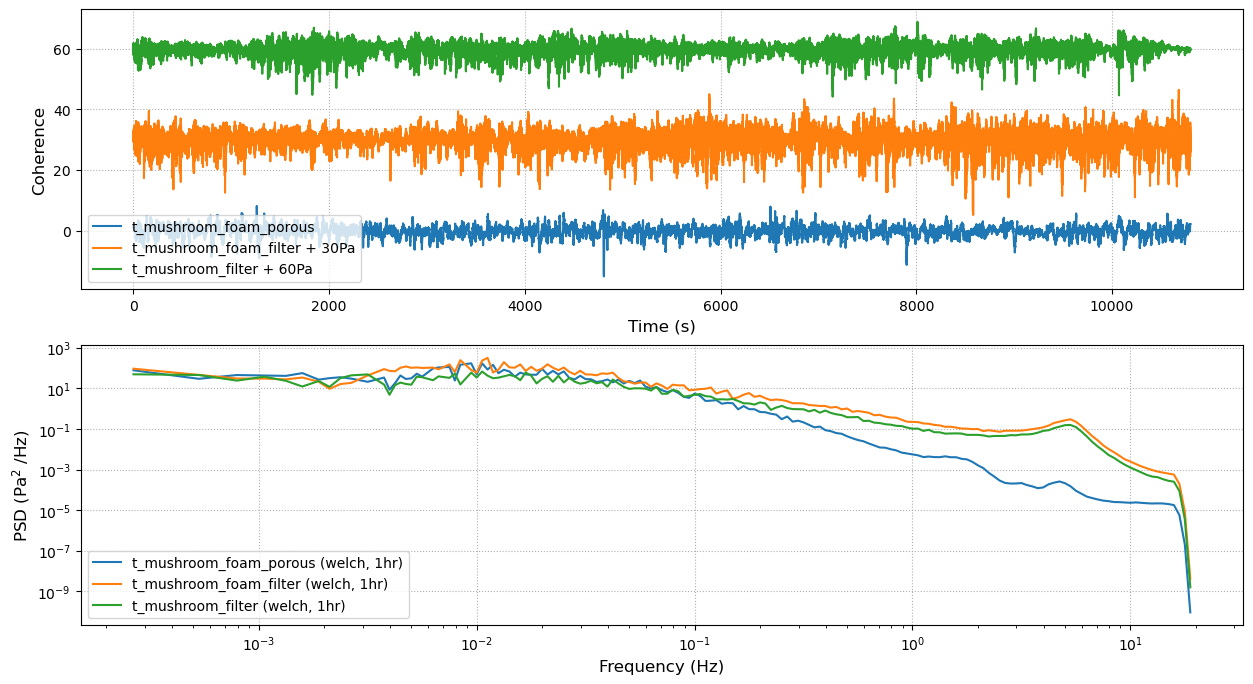

In [203]:
def __makeplot():

    Nrow, Ncol = 2, 1

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8))

    ax[0].plot(data1['time'], data1['data'], label=f"{data1['name']}")
    ax[0].plot(data2['time'], data2['data']+30, label=f"{data2['name']} + 30Pa")
    ax[0].plot(data3['time'], data3['data']+60, label=f"{data3['name']} + 60Pa")

    ax[1].loglog(data1['freq'], data1['psd'], label=f"{data1['name']} (welch, 1hr)")
    ax[1].loglog(data2['freq'], data2['psd'], label=f"{data2['name']} (welch, 1hr)")
    ax[1].loglog(data3['freq'], data3['psd'], label=f"{data3['name']} (welch, 1hr)")

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=3)

    ax[0].set_ylabel("Coherence", fontsize=font)
    ax[0].set_xlabel("Time (s)", fontsize=font)

    ax[1].set_ylabel("PSD (Pa$^2$ /Hz)", fontsize=font)
    ax[1].set_xlabel("Frequency (Hz)", fontsize=font)

    plt.show();
    return fig


fig = __makeplot();

fig.savefig(path_to_figs+f"Compare_MB2005_inlets.png", format="png", dpi=200, bbox_inches='tight')